## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns

from tensorflow.keras.datasets import mnist
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from PIL import Image

## Creating the input images

### MNIST Set

In [2]:
class CreateImages:
    def __init__(self, n_imag, n_img_test, size_image, digits, padding, detector_scale=1):
        self.n_imag = n_imag
        self.n_img_test = n_img_test
        self.size_image = size_image
        self.padding = padding
        self.digits = digits
        self.detector_scale = detector_scale #scales detector size
        self.n_digits = len(self.digits)
        self.grids = {}
        ps = 8e-6
        length = 1000
        self.pixel_size = (ps*length)/self.size_image
    
        for idx, d in enumerate(self.digits):
            self.grids[d] = self.create_output_grid(idx + 1)

    #This is for the input to ONN - saves dictionary with labels and grid positions which correspond
    def return_grids(self):
        grid_values = {}
        for idx,d in enumerate(self.digits):
            grid_values[d] = self.return_grid_pos(idx+1)
        return grid_values
            
    #Filter the dataset to get only images of specific digits
    def filter_digits(self, x_data, y_data):
        idx = np.isin(y_data, self.digits)
        return x_data[idx], y_data[idx]

    def resize_images(self, images, padding):
        resized_images = []
        inner_size = self.size_image - 2 * padding  
    
        for image in images:
            resized_image = tf.image.resize(image[..., np.newaxis], 
                                            [inner_size, inner_size], method='nearest').numpy().squeeze()
    
            padded_image = np.zeros((self.size_image, self.size_image))
    
            start = padding
            end = padding + inner_size
    
            padded_image[start:end, start:end] = resized_image
            resized_images.append(padded_image)
    
        return np.array(resized_images)
            
    def create_output_grid(self, label):
        output_grid = np.zeros((self.size_image, self.size_image))
        if self.n_digits < 5:
            max_cols = 2
        else:
            max_cols = 3
        cols = min(max_cols, self.n_digits)
        rows = int(np.ceil(self.n_digits / cols))
    
        margin_ratio = 0.14
        margin_px = int(self.size_image * margin_ratio)
    
        grid_width = self.size_image - 2 * margin_px
        step = grid_width // (2 * max(rows, cols) - 1)
    
        total_grid_width = step * (2 * (cols - 1) + 1)
        total_grid_height = step * (2 * (rows - 1) + 1)
        margin_x = (self.size_image - total_grid_width) // 2
        margin_y = (self.size_image - total_grid_height) // 2
    
        positions = []
        for i in range(rows):
            for j in range(cols):
                if len(positions) >= self.n_digits:
                    break
                x = margin_x + j * 2 * step
                y = margin_y + i * 2 * step
                positions.append((y, x))
    
        if 1 <= label <= self.n_digits:
            y, x = positions[label - 1]
            det_step = int(step * self.detector_scale)
            y0 = y + (step - det_step) // 2
            x0 = x + (step - det_step) // 2
            output_grid[y0:y0 + det_step, x0:x0 + det_step] = 1
                
        return output_grid

    def return_grid_pos(self, label):
        if self.n_digits < 5:
            max_cols = 2
        else:
            max_cols = 3
        cols = min(max_cols, self.n_digits)
        rows = int(np.ceil(self.n_digits / cols))
    
        margin_ratio = 0.14
        margin_px = int(self.size_image * margin_ratio)
    
        grid_width = self.size_image - 2 * margin_px
        step = grid_width // (2 * max(rows, cols) - 1)
    
        total_grid_width = step * (2 * (cols - 1) + 1)
        total_grid_height = step * (2 * (rows - 1) + 1)
        margin_x = (self.size_image - total_grid_width) // 2
        margin_y = (self.size_image - total_grid_height) // 2
    
        pos = []
        for i in range(rows):
            for j in range(cols):
                if len(pos) >= self.n_digits:
                    break
                x = margin_x + j * 2 * step
                y = margin_y + i * 2 * step
                pos.append((y, x))
    
        grid_pos = []
        if 1 <= label <= self.n_digits:
            y, x = pos[label - 1]
            det_step = int(step * self.detector_scale)
            y0 = y + (step - det_step) // 2
            x0 = x + (step - det_step) // 2
            grid_pos.append([y0, y0 + det_step, x0, x0 + det_step])
        return grid_pos


    def process(self):
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        
        #Get only the digits you want to work with
        x, y_label = self.filter_digits(x_train, y_train)
        x_test,y_label_test = self.filter_digits(x_test, y_test)

        #Shuffle the data
        x, y_label = shuffle(x, y_label)

        #Get number of digits
        x = x[:self.n_imag]  
        y_label = y_label[:self.n_imag]
        x_test = x_test[:self.n_img_test]  
        y_label_test = y_label_test[:self.n_img_test]

        #Resize the number of digits
        x = self.resize_images(x,self.padding)/ 255.0 
        x_test = self.resize_images(x_test,self.padding)/ 255.0 

        #Create a goal output grid
        y = np.array([self.grids[label] for label in y_label])
        y_test = np.array([self.grids[label] for label in y_label_test])
        y = self.resize_images(y,0) 
        y_test = self.resize_images(y_test,0)

        print("Inputs shape: ", x.shape)  
        print("Output shape: ", y.shape)  
        print("Label shape: ", y_label.shape)
        print("Input Test shape: ", x_test.shape) 
        print("Output Test shape: ", y_test.shape)  
        print("Label Test shape: ", y_label_test.shape)

        return x, y, y_label,x_test,y_test,y_label_test

    def plotimage(self,x,y,y_label):
        i = np.random.randint(0,self.n_imag)
        
        fig, axs = plt.subplots(1, 2)

        axs[0].imshow(x[i],cmap="Blues")
        axs[0].set_title(f"Input Image, Class {y_label[i]}")
        axs[0].axis("off")  

        axs[1].imshow(y[i],cmap="Blues")
        axs[1].set_title(f"Output Image, Class {y_label[i]}")
        axs[1].axis("off")  

        desired_length_um = 1000  # microns
        bar_length_px = int(desired_length_um / (self.pixel_size * 1e6))
        
        bar_thickness = 2
        tick_height = 6
        margin_px = 16
        label_offset_px = 14
        
        #Coordinates within the image
        x_end = self.size_image - margin_px
        x_start = x_end - bar_length_px
        y_bar = self.size_image - margin_px
        #Draw horizontal bar
        axs[0].plot([x_start, x_end], [y_bar, y_bar], color='black', linewidth=bar_thickness)
        
        #Draw tick marks at ends
        axs[0].plot([x_start, x_start], [y_bar - tick_height/2, y_bar + tick_height/2], color='black', linewidth=1.5)
        axs[0].plot([x_end+0.6, x_end+0.6], [y_bar - tick_height/2, y_bar + tick_height/2], color='black', linewidth=1.5)
        
        #Add label centered below the bar
        axs[0].text(
            (x_start + x_end) / 2,
            y_bar + label_offset_px,
            f"{desired_length_um} μm",
            ha='center',
            va='bottom',
            fontsize=9,
            color='black'
        )

        axs[1].plot([x_start, x_end], [y_bar, y_bar], color='black', linewidth=bar_thickness)
        
        #Draw tick marks at ends
        axs[1].plot([x_start, x_start], [y_bar - tick_height/2, y_bar + tick_height/2], color='black', linewidth=1.5)
        axs[1].plot([x_end+0.6, x_end+0.6], [y_bar - tick_height/2, y_bar + tick_height/2], color='black', linewidth=1.5)

        #Add label centered below the bar
        axs[1].text(
            (x_start + x_end) / 2,
            y_bar + label_offset_px,
            f"{desired_length_um} μm",
            ha='center',
            va='bottom',
            fontsize=9,
            color='black'
        )
      
        plt.tight_layout()
        plt.show()
        return

    def visualize_grids(self):
        n = self.n_digits
        cols = min(5, n)
        rows = int(np.ceil(n / cols))
        grid_plot = np.zeros((self.size_image,self.size_image))
        
        for i in range(rows * cols):
            if i < n:
                digit = self.digits[i]
                grid = self.grids[digit]
                grid_plot += grid
                
        plt.imshow(grid_plot,cmap="Blues")
        plt.title("Grid Locations")

        desired_length_um = 1000  # microns
        bar_length_px = int(desired_length_um / (self.pixel_size * 1e6))
        
        bar_thickness = 2
        tick_height = 6
        margin_px = 16
        label_offset_px = 14
        
        #Coordinates within the image
        x_end = self.size_image - margin_px
        x_start = x_end - bar_length_px
        y_bar = self.size_image - margin_px
        #Draw horizontal bar
        plt.plot([x_start, x_end], [y_bar, y_bar], color='black', linewidth=bar_thickness)
        
        # Draw tick marks at ends
        plt.plot([x_start, x_start], [y_bar - tick_height/2, y_bar + tick_height/2], color='black', linewidth=1.5)
        plt.plot([x_end+0.6, x_end+0.6], [y_bar - tick_height/2, y_bar + tick_height/2], color='black', linewidth=1.5)
        
        # Add label centered below the bar
        plt.text(
            (x_start + x_end) / 2,
            y_bar + label_offset_px,
            f"{desired_length_um} μm",
            ha='center',
            va='bottom',
            fontsize=9,
            color='black'
        )
        plt.tight_layout()
        plt.axis("off") 
        plt.colorbar()
        plt.show()

In [3]:
n_imag = 5000 #number of training images
n_img_test = 1000 #number of testing set images
size_image = 200 #size of images (x,x)

C = CreateImages(n_imag, n_img_test, size_image, digits=[0,1,2,3,4,5,6,7,8,9],padding=8,detector_scale=1)

In [4]:
x, y, y_label, x_test, y_test, y_l_test  = C.process()

Inputs shape:  (5000, 200, 200)
Output shape:  (5000, 200, 200)
Label shape:  (5000,)
Input Test shape:  (1000, 200, 200)
Output Test shape:  (1000, 200, 200)
Label Test shape:  (1000,)


In [5]:
#Save the grids dictionary and label
defined_grids = C.return_grids()

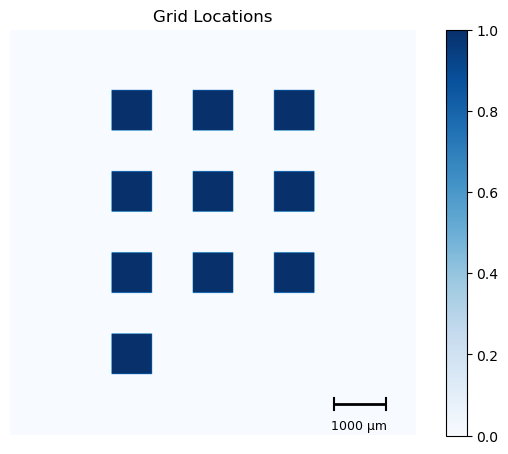

In [ ]:
C.visualize_grids() #visualizes the grid location

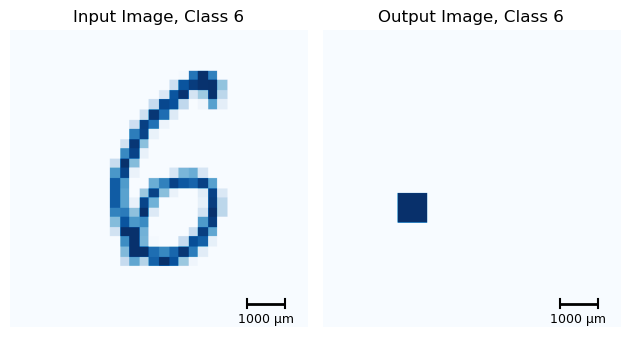

In [ ]:
C.plotimage(x,y,y_label) #plots a random input and output in the data set

# Classifying ONN with logical detector layer

In [ ]:
class ONN_Class_Det:
    def __init__(self, size, n_L, sub_grids, wavelength, z, pixel_size):
        self.n_L = n_L
        self.size = size
        self.sub_grids = sub_grids
        self.n_class = len(sub_grids.keys())
        self.pixel_size = pixel_size

        #Initialize weights (phase masks)
        self.weights = 2 * np.pi * np.random.rand(self.n_L - 1, self.size, self.size).astype(np.float32)

        #Angular spectrum transfer function
        fx = np.fft.fftfreq(self.size, pixel_size)
        fx = np.fft.fftshift(fx)
        fy = np.fft.fftfreq(self.size, pixel_size)
        fy = np.fft.fftshift(fy)
        FX, FY = np.meshgrid(fx, fy)
        kz = (2 * np.pi)**2 * ((1/wavelength) ** 2 - FX**2 - FY**2)
        self.H = np.exp(1j * z * kz).astype(np.complex64)

        #Build detector masks
        self.detectors = []
        for label, ranges in self.sub_grids.items():
            y1, y2, x1, x2 = ranges[0]
            mask = np.zeros((self.size, self.size))
            mask[y1:y2, x1:x2] = 1.0
            self.detectors.append(mask)
        
    def ft(self, x):
        return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(x)))

    def ift(self, x):
        return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(x)))

    def forward(self, X):
        a = [X]
        for i in range(self.n_L - 1):
            m = a[i] * np.exp(1j * self.weights[i])
            p = self.ift(self.ft(m) * self.H)
            a.append(p)
        return np.array(a)

    def calc_logits(self, intensity):
        logits = []
        for det in self.detectors:
            logits.append(np.sum(intensity * det))
        return np.array(logits)
        
    def compute_softmax_loss_grad(self, logits, label_idx):
        #Softmax and cross-entropy loss gradient w.r.t. logits
        exps = np.exp(logits - np.max(logits))
        softmax = exps / np.sum(exps)
        dL_dlogits = softmax
        dL_dlogits[label_idx] -= 1  
        return dL_dlogits
    
    def backprop(self, X, label):
        a = X
        final_field = X[self.n_L - 1]
        intensity = np.abs(final_field)**2
        logits = self.calc_logits(intensity)
        dL_dlogits = self.compute_softmax_loss_grad(logits, label)

        #Backpropagation final layer
        dL_dI = sum(
            dL_dlogits[k] * self.detectors[k]
            for k in range(self.n_class)
        )

        dI_da = 2 * np.conj(final_field)
        dL_da = dL_dI * dI_da

        dEda = np.zeros_like(self.weights, dtype=np.complex64)
        dEdW = np.zeros_like(self.weights, dtype=np.complex64)
        dEda[self.n_L - 2] = dL_da
        fft_back = self.ift(self.ft(dEda[self.n_L - 2]) * self.H)
        dEdW[self.n_L - 2] = 1j * X[self.n_L - 2] * np.exp(1j * self.weights[self.n_L - 2]) * fft_back

        #Backpropagate through remaining layers
        for l in range(self.n_L - 3, -1, -1):
            dEda[l] = np.exp(1j * self.weights[l + 1]) * fft_back
            fft_back = self.ift(self.ft(dEda[l]) * self.H)  
            dEdW[l] = 1j * X[l] * np.exp(1j * self.weights[l]) * fft_back

        gradient_norm = np.linalg.norm(dEdW) + 1e-6 
        dEdW /= gradient_norm
            
        return np.real(dEdW) / self.size**2

    def train(self, X, y_labels, epochs=100, batch_size=32, learning_rate=0.01):
        n = len(X)
        loss_history = []
        acc_history = []
        g_history = []

        decay_rate = 1

        for epoch in range(epochs):
            indices = np.arange(n)
            np.random.shuffle(indices)
            learning_rate = learning_rate * (decay_rate ** (epoch)) 
            total_loss = 0
            correct = 0

            for start in range(0, n, batch_size):
                end = min(start + batch_size, n)
                batch_idx = indices[start:end]

                grad_batch = np.zeros_like(self.weights)
                for idx in batch_idx:
                    Xf = self.forward(X[idx])
                    aL = Xf[-1]
                    logits = self.calc_logits(np.abs(aL)**2)
                    logits -= np.max(logits) #prevent overflow
                    pred = np.argmax(logits)
        
                    if pred == y_labels[idx]:
                        correct += 1
                        
                    grad_batch += self.backprop(Xf, y_labels[idx])
                    exps = np.exp(logits)
                    softmax = exps / np.sum(exps)
                    total_loss += -np.log(np.clip(softmax[y_labels[idx]], 1e-9, 1.0))
                    
                grad_batch /= len(batch_idx)

                #Adam update
                if epoch == 0:
                    self.m = np.zeros_like(self.weights)
                    self.v = np.zeros_like(self.weights)
                    self.t = 0
                    self.beta1 = 0.9
                    self.beta2 = 0.999
                    self.epsilon = 1e-8

                self.t += 1
                self.m = self.beta1 * self.m + (1 - self.beta1) * grad_batch
                self.v = self.beta2 * self.v + (1 - self.beta2) * (grad_batch ** 2)
                m_hat = self.m / (1 - self.beta1 ** self.t)
                v_hat = self.v / (1 - self.beta2 ** self.t)
                self.weights -= learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
                self.weights = self.weights % (2 * np.pi)

            acc = correct / n
            avg_loss = total_loss / n
            loss_history.append(avg_loss)
            acc_history.append(acc)
            mean_grads_per_layer = [np.mean(np.abs(g)) for g in grad_batch]
            g_history.append(mean_grads_per_layer)

            if epoch % 2 == 0: #only shows every two epochs
                print(f"Epoch {epoch}: Loss={avg_loss:.6f}, Accuracy={acc:.4f}")

        return loss_history, acc_history, self.weights, g_history 

    def predict(self, X):
        return self.forward(X)

    def calc_predicted_label(self, image):
        logits = self.calc_logits(np.abs(image)**2)
        return np.argmax(logits)

    def plot_la(self, loss, acc): #Plot the loss versus accuracy
        import matplotlib as mpl
        mpl.style.use('default')
        
        epochs = np.arange(1, len(loss) + 1)
        fig, ax1 = plt.subplots(figsize=(8, 6))
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss', color='blue')
        ax1.plot(epochs,loss, color='blue', label='Loss', linewidth=2, marker='o')
        ax1.tick_params(axis='y', labelcolor='blue')

        ax2 = ax1.twinx()
        ax2.set_ylabel('Accuracy', color='red')
        ax2.plot(epochs,acc, color='red', label='Accuracy',linewidth=2, marker='o')
        ax2.tick_params(axis='y', labelcolor='red')

        plt.title("Loss and Accuracy versus Epochs")
        fig.tight_layout()
        plt.show()

    def plot_output(self, X, y, y_labels, idx): #Plot the output at each plane
        x_pred = self.predict(X[idx])
        predicted_label = self.calc_predicted_label(x_pred[self.n_L - 1])

        fig, axs = plt.subplots(1, self.n_L + 2, figsize=(3 * self.n_L, 3))

        for i in range(self.n_L + 2):
            if i == 0:
                axs[i].imshow(np.imag(np.log(X[idx])), cmap='ocean_r')
                axs[i].set_title("Input Phase")
                axs[i].axis("off")
            elif i == self.n_L + 1:
                axs[i].imshow(y[idx], cmap='ocean_r')
                axs[i].set_title(f"Goal Output Intensity - Predicted: {predicted_label}")
                axs[i].axis("off")
            else:
                intensity = np.abs(x_pred[i - 1]) ** 2
                axs[i].imshow(intensity, cmap='ocean_r')
                axs[i].set_title(f"Intensity at Plane {i}")
                axs[i].axis("off")

                if i == self.n_L:
                    for grid_label, ranges in self.sub_grids.items():
                        y1, y2, x1, x2 = ranges[0]
                        color = 'green' if grid_label == y_labels[idx] else 'red'
                        rect = plt.Rectangle((x1 - 0.5, y1 - 0.5), x2 - x1, y2 - y1, linewidth=1.5, edgecolor=color, facecolor='none')
                        axs[i].add_patch(rect)
                    plt.colorbar(axs[i].images[0], ax=axs[i], fraction=0.046, pad=0.04)

        plt.tight_layout()
        plt.show()

    def plot_final_output(self, X, y, y_labels, idx): #Plot the final output and input image
        x_pred = self.predict(X[idx])
        predicted_label = self.calc_predicted_label(x_pred[self.n_L - 1])

        fig, axs = plt.subplots(1, 3, figsize=(6, 6))

        axs[0].imshow(np.abs(X[idx]),cmap='Blues',aspect='equal')
        axs[0].set_title("Input Image")
        axs[0].axis("off")

        axs[2].imshow(y[idx],cmap="Blues",aspect='equal')
        axs[2].set_title(f"Goal Output: {y_labels[idx]}")
        axs[2].axis("off")

        intensity = np.abs(x_pred[self.n_L - 1]) ** 2
        axs[1].imshow(intensity, cmap='Blues',aspect='equal')
        axs[1].set_title(f"Predicted Output: {predicted_label}")
        axs[1].axis("off")

        for grid_label, ranges in self.sub_grids.items():
            y1, y2, x1, x2 = ranges[0]
            color = 'green' if grid_label == y_labels[idx] else 'red'
            rect = plt.Rectangle((x1 - 0.5, y1 - 0.5), x2 - x1, y2 - y1, linewidth=1.5, alpha=.7, edgecolor=color, facecolor='none')
            axs[1].add_patch(rect)
        
        desired_length_um = 1000  #microns
        bar_length_px = int(desired_length_um / (self.pixel_size * 1e6))
        
        bar_thickness = 2
        tick_height = 6
        margin_px = 16
        label_offset_px = 14
        
        x_end = self.size - margin_px
        x_start = x_end - bar_length_px
        y_bar = self.size - margin_px

        axs[1].plot([x_start, x_end], [y_bar, y_bar], color='black', linewidth=bar_thickness)

        axs[1].plot([x_start, x_start], [y_bar - tick_height/2, y_bar + tick_height/2], color='black', linewidth=1.5)
        axs[1].plot([x_end+1, x_end+1], [y_bar - tick_height/2, y_bar + tick_height/2], color='black', linewidth=1.5)
        
        axs[1].text(
            (x_start + x_end) / 2,
            y_bar + label_offset_px,
            f"{desired_length_um} μm",
            ha='center',
            va='bottom',
            fontsize=9,
            color='black'
        )
        
        plt.tight_layout()
        plt.show()

    def plot_cm(self, X, y_labels): #Plot the confusion matrix
        n = len(X)
        y_pred = []
        for i in range(n):
            x_pred = self.predict(X[i])
            pred = self.calc_predicted_label(x_pred[self.n_L - 1])
            y_pred.append(pred)

        cm = confusion_matrix(y_labels, y_pred, labels=list(self.sub_grids.keys()))

        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(self.sub_grids.keys()), yticklabels=list(self.sub_grids.keys()))
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

    def plot_detector_distribution(self, X, y_labels, idx): #Plot the detector distribution
        import matplotlib as mpl
        mpl.style.use('seaborn-v0_8')
        x_pred = self.predict(X[idx])
        final_intensity = np.abs(x_pred[self.n_L - 1])**2
    
        logits = self.calc_logits(final_intensity)
        norm_logits = logits / (np.sum(logits) + 1e-9)
    
        fig, ax = plt.subplots(figsize=(6, 2.5))
        bar_colors = plt.cm.Blues(norm_logits / norm_logits.max())
        bars = ax.bar(range(self.n_class), norm_logits, width=0.5, color=bar_colors)
    
        ax.set_xticks(range(self.n_class))
        ax.set_xticklabels([str(k) for k in self.sub_grids.keys()])
        ax.set_ylabel("Normalized Intensity", fontsize=10)

        max_val = norm_logits.max()
        ax.set_ylim(0, max_val * 1.15) 
    
        for i, bar in enumerate(bars):
            if i == y_labels[idx]:
                bar.set_edgecolor('green')
                bar.set_linewidth(2)
    
        plt.tight_layout()
        plt.show()

In [51]:
ONNd = ONN_Class_Det(size, n_L, sub_grids, wavelength, z, pixel_size) 

In [52]:
lossd, accd, wd, gd = ONNd.train(x, y_label, epochs, batch_size, learning_rate)

Epoch 0: Loss=1.528511, Accuracy=0.8392
Epoch 2: Loss=0.919501, Accuracy=0.9064
Epoch 4: Loss=0.795939, Accuracy=0.9208
Epoch 6: Loss=0.761201, Accuracy=0.9246
Epoch 8: Loss=0.734652, Accuracy=0.9290
Epoch 10: Loss=0.676063, Accuracy=0.9288
Epoch 12: Loss=0.683507, Accuracy=0.9314
Epoch 14: Loss=0.681527, Accuracy=0.9344
Epoch 16: Loss=0.655919, Accuracy=0.9340
Epoch 18: Loss=0.630011, Accuracy=0.9368
Epoch 20: Loss=0.619087, Accuracy=0.9400
Epoch 22: Loss=0.640300, Accuracy=0.9378
Epoch 24: Loss=0.598305, Accuracy=0.9386


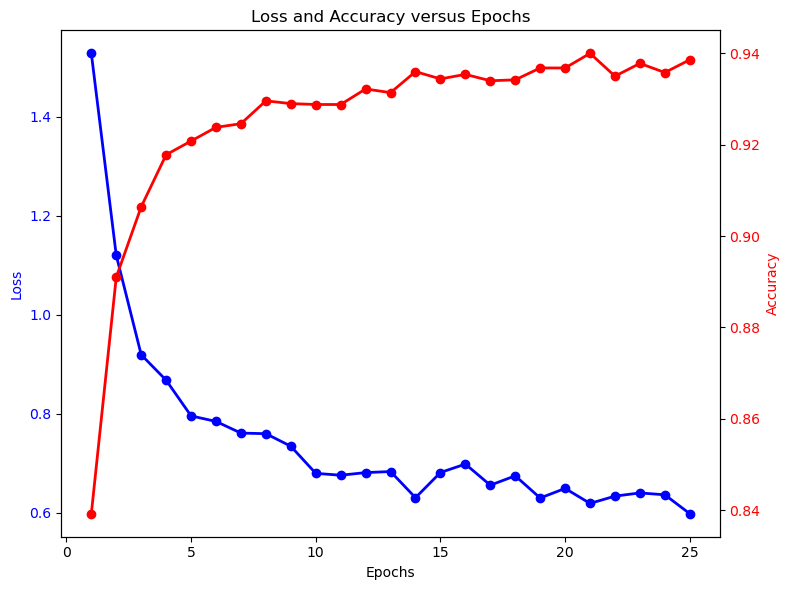

In [53]:
ONNd.plot_la(lossd, accd)

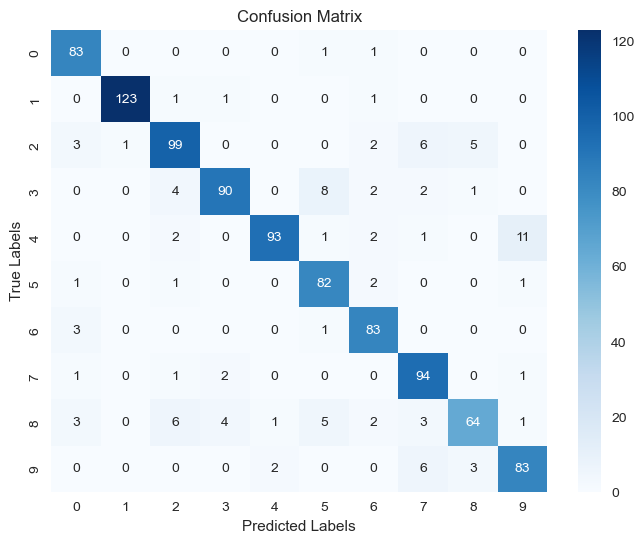

In [62]:
ONNd.plot_cm(x_test,y_l_test)

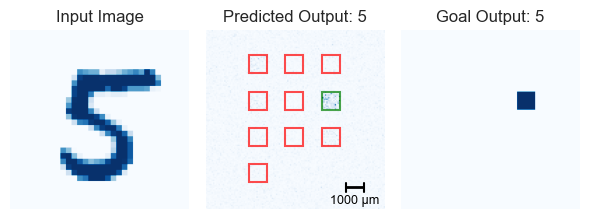

In [61]:
ONNd.plot_final_output(x_test,y_test,y_l_test,162)

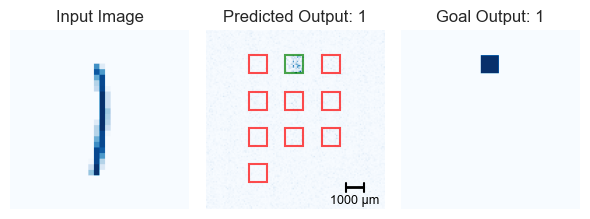

In [60]:
ONNd.plot_final_output(x_test,y_test,y_l_test,40)

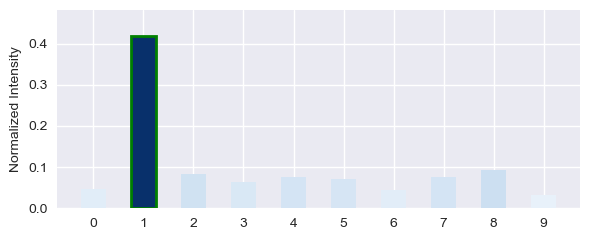

In [59]:
ONNd.plot_detector_distribution(x_test,y_l_test,40)

# Generation of Arbitrary Linear Transformations

In [ ]:
class CreateI_LT:
    def __init__(self, n_imag,size_image, padding):
        self.n_imag = n_imag
        self.size_image = size_image
        self.padding = padding
        self.grids = {}
        ps = 8e-6
        length = 1000
        self.pixel_size = (ps*length)/self.size_image
    
    def resize_images(self, images, padding):
        resized_images = []
        inner_size = self.size_image - 2 * padding  
    
        for image in images:
            resized_image = tf.image.resize(image[..., np.newaxis], 
                                            [inner_size, inner_size], method='nearest').numpy().squeeze()
    
            padded_image = np.zeros((self.size_image, self.size_image))
            start = padding
            end = padding + inner_size
            padded_image[start:end, start:end] = resized_image
            resized_images.append(padded_image)
    
        return np.array(resized_images)
            
    def process(self,x,y):
        #Shuffle the data
        x, y = shuffle(x, y)

        #Get however many images you want
        x = x[:self.n_imag]  
        y = y[:self.n_imag]

        #Resize the number of digits
        x = self.resize_images(x,self.padding)/255.0 

        #Create a goal output grid
        y = self.resize_images(y,self.padding)/255.0

        print("Inputs shape: ", x.shape)  
        print("Output shape: ", y.shape)  

        return x, y

    def plotimage(self,x,y):
        i = np.random.randint(0,self.n_imag)
        
        fig, axs = plt.subplots(1, 2)

        axs[0].imshow(x[i],cmap="Blues", aspect='equal')
        axs[0].set_title(f"Input Image")
        axs[0].axis("off")  

        axs[1].imshow(y[i],cmap="Blues", aspect='equal')
        axs[1].set_title(f"Output Image")
        axs[1].axis("off")  

        desired_length_um = 1000  #microns
        bar_length_px = int(desired_length_um / (self.pixel_size * 1e6))
        
        bar_thickness = 2
        tick_height = 8
        margin_px = 16
        label_offset_px = 20
        
        x_end = self.size_image - margin_px - label_offset_px
        x_start = x_end - bar_length_px
        bar_offset_px = 50 
        y_bar = self.size_image - bar_offset_px
        
        axs[0].plot([x_start, x_end], [y_bar, y_bar], color='black', linewidth=bar_thickness, zorder=10)
        
        axs[0].plot([x_start, x_start], [y_bar - tick_height/2, y_bar + tick_height/2], color='black', linewidth=1.5)
        axs[0].plot([x_end+0.6, x_end+0.6], [y_bar - tick_height/2, y_bar + tick_height/2], color='black', linewidth=1.5)
        
        axs[0].text(
            (x_start + x_end) / 2 - label_offset_px*1.5,
            y_bar - label_offset_px,
            f"{desired_length_um} μm",
            ha='center',
            va='bottom',
            fontsize=9,
            color='black'
        )

        axs[1].plot([x_start, x_end], [y_bar, y_bar], color='black', linewidth=bar_thickness, zorder=10)
        axs[1].plot([x_start, x_start], [y_bar - tick_height/2, y_bar + tick_height/2], color='black', linewidth=1.5)
        axs[1].plot([x_end+0.6, x_end+0.6], [y_bar - tick_height/2, y_bar + tick_height/2], color='black', linewidth=1.5)
        
        axs[1].text(
            (x_start + x_end) / 2 - label_offset_px*1.5,
            y_bar - label_offset_px,
            f"{desired_length_um} μm",
            ha='center',
            va='bottom',
            fontsize=9,
            color='black'
        )
          
        plt.tight_layout()
        plt.show()
        return

In [57]:
class ONN_Class:
    def __init__(self, size, n_L, sub_grids, wavelength, z, pixel_size):
        self.n_L = n_L #Number of layers
        self.size = size #Size of grid
        self.sub_grids = sub_grids #Location and class subgrids
        if self.sub_grids != None:
            self.n_class = len(self.sub_grids.keys()) #Number of classes
        
        #Initialize weights 
        self.weights =  2 * np.pi * np.random.rand(self.n_L - 1, self.size, self.size) 

        #Initialize Function for Angular Spectrum
        fx = np.fft.fftfreq(self.size,pixel_size)
        fx = np.fft.fftshift(fx)
        fy = np.fft.fftfreq(self.size,pixel_size)
        fy = np.fft.fftshift(fy)
        FX, FY = np.meshgrid(fx, fy) 
        self.FX = FX
        self.FY = FY
        kz = (2 * np.pi)**2 * ((1. / wavelength) ** 2 - self.FX**2 - self.FY**2) 
        H = np.exp(1j * z * kz)
        self.H = H

    def compile(self, optimizer="adam", **kwargs):
        if optimizer.lower() not in ["adam", "sgd"]:
            raise ValueError("Use 'adam' or 'sgd'.")

        self.optimizer = optimizer.lower()
        self.optimizer_params = kwargs  

        if self.optimizer == "adam":
            self.m = np.zeros_like(self.weights) 
            self.v = np.zeros_like(self.weights)  
            self.t = 0 
            self.beta1 = kwargs.get("beta1", 0.9)
            self.beta2 = kwargs.get("beta2", 0.999)
            self.epsilon = kwargs.get("epsilon", 1e-8)
            
    def non_lin(self, x):
        return np.abs(x)**2 

    def ft(self, s):
        return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(s)))
    def ift(self, s):
        return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(s)))

    def forward(self, X):
        a = [X]

        #Iterate over each layer
        for i in range(self.n_L-1):
            #Linear transformation
            a.append(self.ift(self.ft(a[i]*np.exp(1j*self.weights[i]))*self.H))
        
        #Note non-linearity applied seperately
        a = np.array(a)
        return a

    def calc_predicted_label(self, image):
        max_value = -float('inf')
        predicted_label = -1
    
        for grid_label, ranges in self.sub_grids.items():
            y1, y2, x1, x2 = ranges[0]

            #Check each sub grid and determine which has highest value
            if np.sum(image[y1:y2, x1:x2]) > max_value:
                max_value = np.sum(image[y1:y2, x1:x2])
                predicted_label = grid_label
        return predicted_label

    def compute_loss(self, y_pred, y_true): 
        return np.mean(np.square(np.abs(y_pred)**2 - y_true))

    def backprop(self, X, y_true):
        #Initialize dEdW the cost function gradient and the gradient at w.r.t each neuron
        dEdW = np.zeros_like(self.weights,dtype = 'complex_')
        dEda = np.zeros_like(self.weights,dtype = 'complex_')    
    
        #Calculate explicitly DeDa for last layer
        dEdma = 2*(np.abs(X[self.n_L-1])**2 - y_true) #this is the derivative of the magnitude squared
        dmada = 2*np.conj(X[self.n_L-1])
        dEda[self.n_L-2] = dEdma*dmada
        fft_back = self.ift(self.ft(dEda[self.n_L - 2]) * self.H)
        #Calculating weight matrix for last layer
        dEdW[self.n_L-2] = 1j*X[self.n_L-2]*np.exp(1j*self.weights[self.n_L-2])* fft_back

        #Moving to all other layers
        for l in range(self.n_L-3,-1,-1):
            #Calculating for dEdA
            dEda[l] = np.exp(1j*self.weights[l+1])*fft_back
            #Calculate derivative of cost function w.r.t weights
            fft_back = self.ift(self.ft(dEda[l]) * self.H)  
            dEdW[l] = 1j*X[l]*np.exp(1j*self.weights[l])*fft_back

        #Backpropagate through remaining layers
        for l in range(self.n_L - 3, -1, -1):
            dEda[l] = np.exp(1j * self.weights[l + 1]) * fft_back
            fft_back = self.ift(self.ft(dEda[l]) * self.H) 
            dEdW[l] = 1j * X[l] * np.exp(1j * self.weights[l]) * fft_back
            
        return np.real(dEdW) / self.size**2          
    
    def train(self, X, y, y_labels, epochs=101, batch_size = 32, lr=0.01):
        #Define array of loss values
        loss = []
        acc = []
        n = len(X)
        
        if not self.optimizer:
            raise RuntimeError("Error: Choose Optimizer")

        #Decay Learning rate
        decay_rate = .98

        g = []
        for epoch in range(epochs):
            if epoch % 2 == 0:
                print(f"Epoch {epoch}:")
            lr = lr * (decay_rate ** (epoch)) #blah

            indices = np.arange(n)  #Shuffling indices implements random iteration through data
            np.random.shuffle(indices)
            
            #Initialize variables for tracking loss and accuracy
            Loss = 0
            pred_count = 0
    
            #Iterate over the dataset in batches
            for start_idx in range(0, n, batch_size):
                end_idx = min(start_idx + batch_size, n)
                batch_indices = indices[start_idx:end_idx]
    
                #Initialize gradients for the batch
                dEdW_batch = np.zeros_like(self.weights)
    
                for idx in batch_indices:
                    #Forward pass
                    a = self.forward(X[idx])
                    #Compute loss for the current sample
                    Loss += self.compute_loss(a[self.n_L-1], y[idx])
                    #Add to accuracy count if prediction matches label
                    if y_labels != None:
                        if self.calc_predicted_label(np.abs(a[self.n_L-1])**2) == y_labels[idx]:
                           pred_count += 1
                    #Backpropagation for the current sample
                    dEdW_batch += self.backprop(a, y[idx])
    
                #Average the gradients over the batch
                dEdW_batch /= len(batch_indices) 

                #Run the Optimizer
                if self.optimizer == "adam":
                    self.t += 1
                    self.m = self.beta1 * self.m + (1 - self.beta1) * dEdW_batch  
                    self.v = self.beta2 * self.v + (1 - self.beta2) * (dEdW_batch ** 2)  
                    m_hat = self.m / (1 - self.beta1 ** self.t)
                    v_hat = self.v / (1 - self.beta2 ** self.t)
                    self.weights -= lr * m_hat / (np.sqrt(v_hat) + self.epsilon) 

                elif self.optimizer == "sgd":
                    self.weights -= lr * dEdW_batch 

                self.weights = self.weights%(2*np.pi)
            
            #Compute average loss and accuracy for the epoch
            avg_loss = Loss / n
            if y_labels != None:
                avg_acc = pred_count / n
                acc.append(avg_acc) 
            else: avg_acc = 0
            loss.append(avg_loss) 
            g.append(dEdW_batch)
    
            if epoch % 2 == 0:
                print(f"Loss: {avg_loss:.6f}, Accuracy: {avg_acc:.6f}")

        return loss, acc, self.weights, g      

    def predict(self, X):
        return self.forward(X)
        
    def plot_l(self, loss):
        #Plots the loss and accuracy over epochs
        fig, ax1 = plt.subplots(figsize=(8, 6))
    
        #Plotting loss 
        ax1.set_xlabel('Epochs', fontsize=14)
        ax1.set_ylabel('Loss', color='blue', fontsize=14)
        ax1.plot(loss, color='blue', label='Loss')
        ax1.tick_params(axis='y', labelcolor='blue',size=12)

        plt.title("Loss versus Epochs")
        fig.tight_layout()
        plt.show()
        
    def plot_output(self, X, y, y_labels, idx):
        x_pred = self.predict(X[idx]) #Feed-forward image
        if y_labels != None:
            predicted_label = self.calc_predicted_label(np.abs(x_pred[self.n_L-1])** 2) #Saves predicted label

        #Plots 
        fig, axs = plt.subplots(1, self.n_L + 2, figsize=(3 * self.n_L, 3))
        
        for i in range(self.n_L + 2):
            if i == 0:
                axs[i].imshow(np.imag(np.log(X[idx])), cmap='Blues')
                axs[i].set_title(f"Input Phase",) #Shows input phase information
                axs[i].axis("off")
            elif i == self.n_L + 1:
                axs[i].imshow(y[idx], cmap='Blues')
                axs[i].set_title(f"Goal Output Intensity")
                axs[i].axis("off")
            else:
                intensity = np.abs(x_pred[i - 1]) ** 2
                axs[i].imshow(intensity, cmap='Blues')
                axs[i].set_title(f"Intensity at Plane {i}")
                axs[i].axis("off")
                        
        plt.tight_layout()
        plt.show()

    def plot_final_output(self, X, y, y_labels, idx):
        x_pred = self.predict(X[idx]) 
        if y_labels != None:
            predicted_label = self.calc_predicted_label(np.abs(x_pred[self.n_L-1])** 2) #Saves predicted label

        #Plots 
        fig, axs = plt.subplots(1, 3, figsize=(6, 6))
        
        axs[0].imshow(np.angle(X[idx]), cmap='Blues')
        axs[0].set_title(f"Input") #Shows input phase information
        axs[0].axis("off")

        axs[2].imshow(y[idx], cmap='Blues')
        axs[2].set_title(f"Goal Output")
        axs[2].axis("off")

        intensity = np.abs(x_pred[self.n_L-1]) ** 2
        axs[1].imshow(intensity, cmap='Blues')
        axs[1].set_title(f"Generated Output")
        axs[1].axis("off")

        if y_labels != None:
            for grid_label, ranges in self.sub_grids.items():
                y1, y2, x1, x2 = ranges[0]
                if grid_label == y_labels[idx]:
                    true_rect = plt.Rectangle(
                        (x1-0.5,y1-0.5), x2-x1, y2-y1, linewidth=1.5, edgecolor='green', facecolor='none'
                    )
                    axs[1].add_patch(true_rect)
                else:       
                    rect = plt.Rectangle(
                        (x1-0.5, y1-0.5), x2-x1, y2-y1, linewidth=1, edgecolor='red', facecolor='none'
                    )
                    axs[1].add_patch(rect)
                
        plt.tight_layout()
        plt.show()

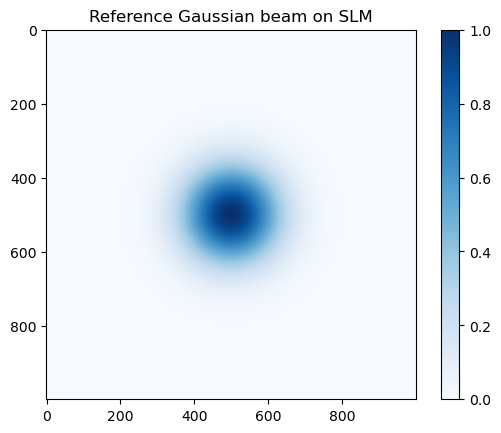

In [65]:
def gauss(size_x,size_y,pixel_size,w0):
    x = np.arange(-size_x/2, size_x/2) * pixel_size
    y = np.arange(-size_y/2, size_y/2) * pixel_size
    xx, yy = np.meshgrid(x, y)
    r = np.sqrt(xx**2 + yy**2)
    intensity = np.exp(-r**2/w0**2)
    return intensity

plt.imshow(gauss(1000,1000,8e-6,1.5e-3)**2,cmap="Blues")
plt.title("Reference Gaussian beam on SLM")
plt.colorbar()

### Create Initial Images

In [53]:
imagex = Image.open("img1.png").convert("L") 
imagex = [np.array(imagex)]

imagey = Image.open("img0.png").convert("L") 
imagey = [np.array(imagey)]

In [54]:
CI = CreateI_LT(1, 1000, 200)

In [55]:
x,y=CI.process(imagex, imagey)

Inputs shape:  (1, 1000, 1000)
Output shape:  (1, 1000, 1000)


### Train Model

In [66]:
ONNc = ONN_Class(size=1000, n_L=3,sub_grids=None, wavelength=795e-9, z=70e-2, pixel_size=1000*8e-6/1000)

In [67]:
ONNc.compile(optimizer="adam", beta1=0.9, beta2=0.999, epsilon=1e-8)
lossp,accp,wp,gp = ONNc.train(gauss(1000,1000,8e-6,1.5e-3)*np.exp(1j*np.pi*2*x),y, None, epochs=35, batch_size = 1, lr=.5)

Epoch 0:
Loss: 0.067245, Accuracy: 0.000000
Epoch 2:
Loss: 0.051012, Accuracy: 0.000000
Epoch 4:
Loss: 0.048847, Accuracy: 0.000000
Epoch 6:
Loss: 0.049443, Accuracy: 0.000000
Epoch 8:
Loss: 0.049229, Accuracy: 0.000000
Epoch 10:
Loss: 0.048434, Accuracy: 0.000000
Epoch 12:
Loss: 0.047467, Accuracy: 0.000000
Epoch 14:
Loss: 0.046575, Accuracy: 0.000000
Epoch 16:
Loss: 0.045886, Accuracy: 0.000000
Epoch 18:
Loss: 0.045428, Accuracy: 0.000000
Epoch 20:
Loss: 0.045162, Accuracy: 0.000000
Epoch 22:
Loss: 0.045025, Accuracy: 0.000000
Epoch 24:
Loss: 0.044963, Accuracy: 0.000000
Epoch 26:
Loss: 0.044937, Accuracy: 0.000000
Epoch 28:
Loss: 0.044927, Accuracy: 0.000000
Epoch 30:
Loss: 0.044924, Accuracy: 0.000000
Epoch 32:
Loss: 0.044923, Accuracy: 0.000000
Epoch 34:
Loss: 0.044923, Accuracy: 0.000000


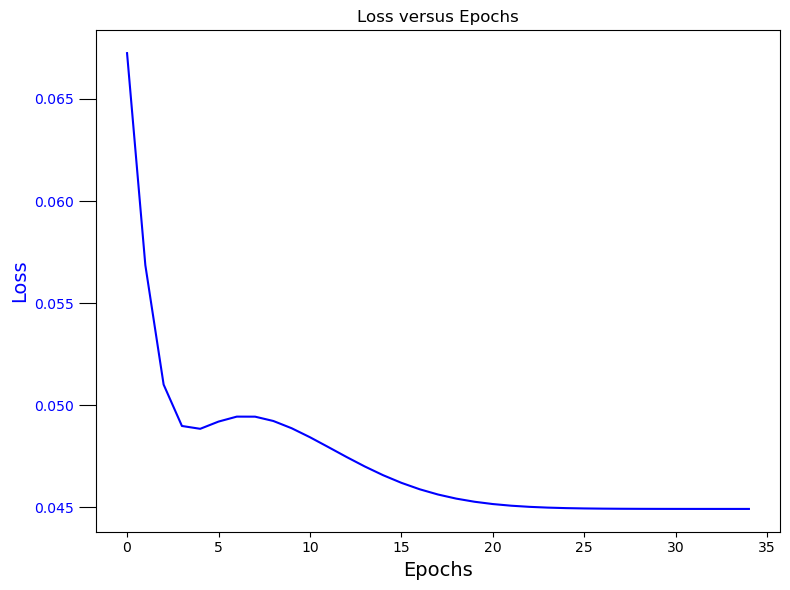

In [68]:
ONNc.plot_l(lossp)

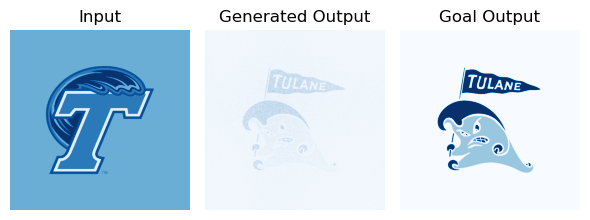

In [69]:
ONNc.plot_final_output(gauss(1000,1000,8e-6,1.5e-3)*np.exp(1j*2*np.pi*x),y,None,0)

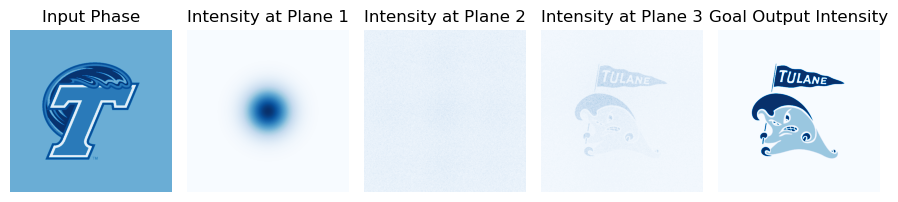

In [71]:
ONNc.plot_output(gauss(1000,1000,8e-6,1.5e-3)*np.exp(1j*2*np.pi*x),y,None,0)